# Dependencies

In [1]:
!pip install --upgrade pip
!pip3 install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2
!pip3 install flask
!pip3 install flask-wtf

In [20]:
#RL libraries
from gym import Env
from gym.spaces import Discrete, Box
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#Neural network libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#Math libraries
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

#Web server libraries
from werkzeug.wrappers import Request, Response
from werkzeug.serving import run_simple
from flask import Flask, render_template, request, redirect, url_for
from wtforms import Form, FloatField, validators

#Visual libraries
import io

In [76]:
app = Flask(__name__)

class InputForm(Form):
    r = FloatField(validators=[validators.InputRequired()])

@app.route("/", methods=["POST", "GET"])
def mainFunction():
    
    form = InputForm(request.form)
    
    if request.method == "POST":

        powerR = form.r.data
        env = WindmillEnv(powerR)
        episodes = 10
        refPower = env.powerRef
        powerArray = []
        anglesArray = []

        for episode in range(1, episodes+1):
            obs = env.reset()
            done = False
            score = 0
    
            powerArray.append(env.genPowerEuler)
            anglesArray.append(env.angle)
    
            while not done:
                action = dqn.forward(obs)
                obs, reward, done, info = env.step(action)
                score += reward
        
                powerArray.append(env.genPowerEuler)
                anglesArray.append(env.angle)
        
                if env.error <= 33.0:
                    break
        
        figure = Figure()
        plt = figure.add_subplot(1,1,1)
        xs = range(90)
        plt.axhline(y=refPower, color='r', linestyle='-')
        plt.plot(powerArray, 'b')
        output = io.BytesIO()
        FigureCanvas(figure).print_png(output)
        return Response(output.getvalue(), mimetype='image/png')

    else:
        
        return render_template("RL.html", form=form)

if __name__ == '__main__':
    run_simple('localhost', 8000, app)

 * Running on http://localhost:8000/ (Press CTRL+C to quit)
127.0.0.1 - - [30/May/2022 20:43:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2022 20:43:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2022 20:43:11] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2022 20:45:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2022 20:45:30] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2022 20:45:45] "GET / HTTP/1.1" 200 -


# Enviroment

In [86]:
class WindmillEnv(Env):
    def __init__(self, pRef):
        
        #Set action space
        self.action_space = Discrete(3)
        
        #Set observation space
        self.observation_space = Box(low=np.array([5]), high=np.array([14]))
        
        #Set training time
        self.training_length = 90
        
        #SET WINDMILL PARAMETERS
        #Static parameters
        self.wind_density = 1.225
        self.radious = 2
        self.flag = pRef
        if pRef == 0:
            self.powerRef = random.uniform(150.0,2900.0)
        else:
            self.powerRef = pRef
        
        #Dynamic parameters
        self.angle = random.uniform(5.0, 14.0)
        self.wind = 10.0
        self.power_eficiency = -0.0422*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
        
    def step(self, action):
        #Save the error from the previous step in a variable
        last_error = self.error
        
        #Reduces training time in 1 second
        self.training_length -= 1
        
        #Apply action
            #0.0 - 0.1 = -0.1 (angle reduces in 0.1)
            #0.1 - 0.1 = 0.0 (angle does not change)
            #0.2 - 0.1 = 0.1 (angle increases in 0.1)
        self.angle += (action/10.0) - 0.1 #AÑADIR MAS ACCIONES
        
        #Euler for Calculating energy
        for t in range(1, 151):
            self.power_eficiency = -0.0422*self.angle + 0.5911
            self.genPowerEuler += ((0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency)/5 - self.genPowerEuler/5)*0.5
        
        #Calculates final error
        self.error = abs(self.powerRef - self.genPowerEuler)
        
        #Calculates reward
        if self.error < last_error:
            reward = 10
        elif self.error == last_error:
            reward = -1
        else:
            reward = -10
        
        #Check if the training finished
        if self.training_length <= 0:
            done = True
        else:
            done = False
            
        #Wind disturbances
        #if self.training_length % 10 == 0:
        #    self.wind += random.uniform(-0.05,0.05)
        
        #placeholder for the info
        info = {}
        
        #Return step information
        return self.angle, reward, done, info
    
    def reset(self):
        #Reset parameters
        self.angle = random.uniform(5, 14)
        self.wind = 10.0
        self.power_eficiency = -0.0422*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
        if self.flag == 0:
            self.powerRef = random.uniform(150.0,2900.0)
        
        #Reset training time
        self.training_length = 90
        
        return self.angle

In [87]:
env = WindmillEnv(0)

Episode:1 Score:136 Angle:10.008446337709037


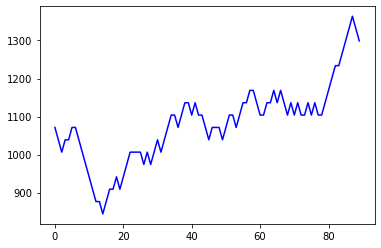

Episode:2 Score:77 Angle:7.835668383650182


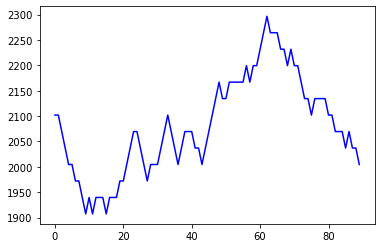

Episode:3 Score:-8 Angle:5.733423322992886


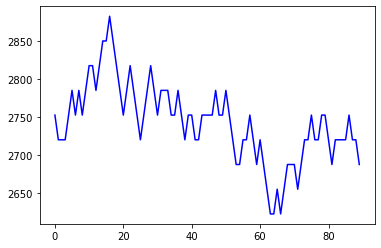

Episode:4 Score:10 Angle:6.539638078948876


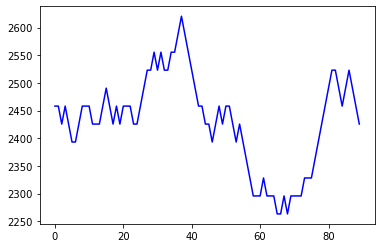

Episode:5 Score:3 Angle:10.192060173120373


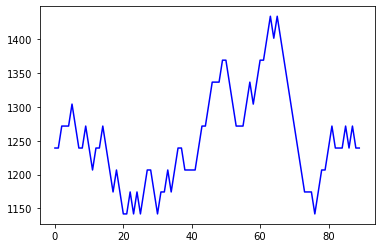

Episode:6 Score:-16 Angle:9.891510604187006


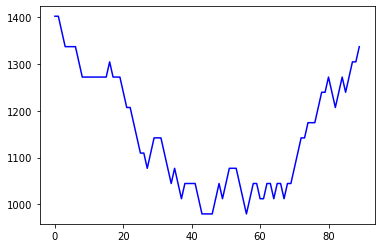

Episode:7 Score:-24 Angle:14.139880009953364


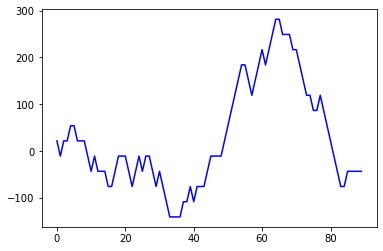

Episode:8 Score:42 Angle:10.02662019902821


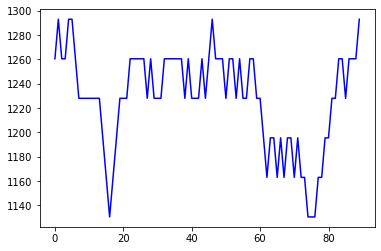

Episode:9 Score:-115 Angle:10.747037993411045


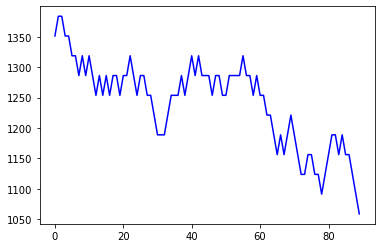

Episode:10 Score:-61 Angle:8.15780784919533


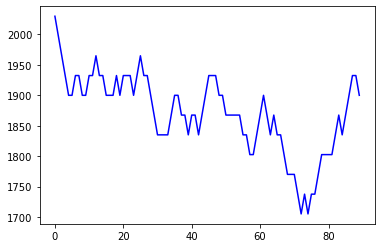

Episode:11 Score:21 Angle:8.368378117686497


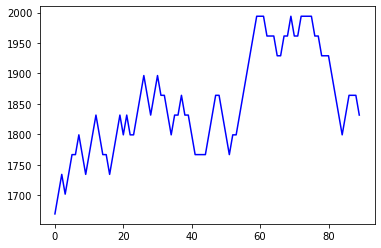

Episode:12 Score:-101 Angle:6.334011377754259


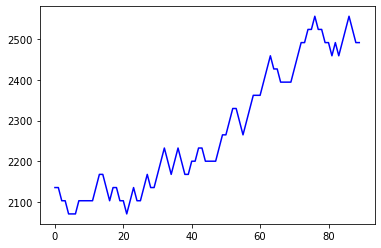

Episode:13 Score:-48 Angle:9.31245781045699


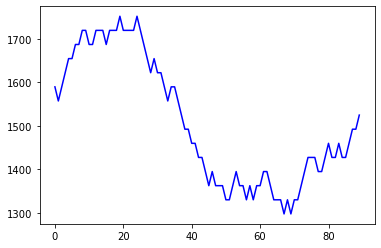

Episode:14 Score:-6 Angle:9.096585079867381


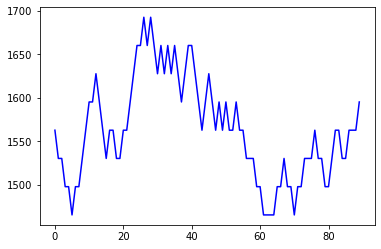

Episode:15 Score:154 Angle:8.906621963750265


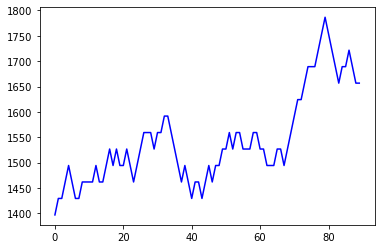

Episode:16 Score:6 Angle:5.102184737558975


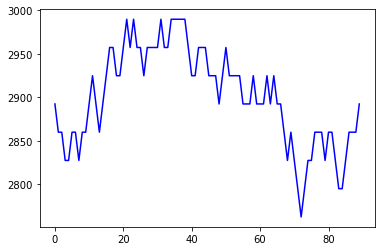

Episode:17 Score:-193 Angle:13.621985528173441


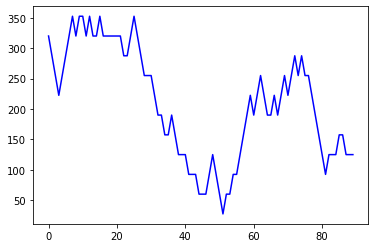

Episode:18 Score:8 Angle:5.192856493378125


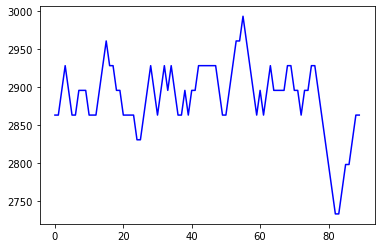

Episode:19 Score:72 Angle:8.985885271812187


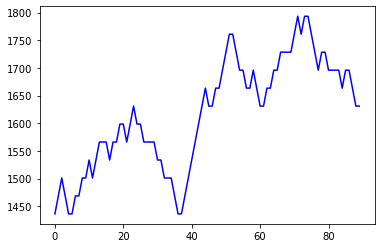

Episode:20 Score:10 Angle:5.885167244292886


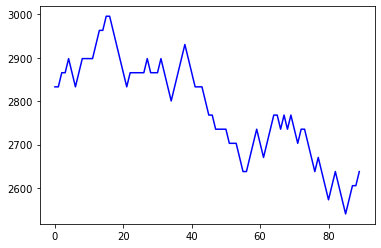

Episode:21 Score:-34 Angle:7.348210006048713


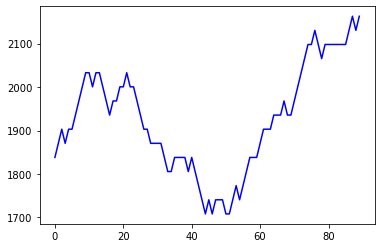

Episode:22 Score:223 Angle:7.22839920521243


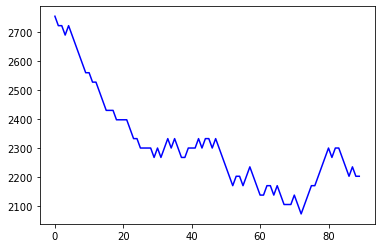

Episode:23 Score:-14 Angle:5.706972066559953


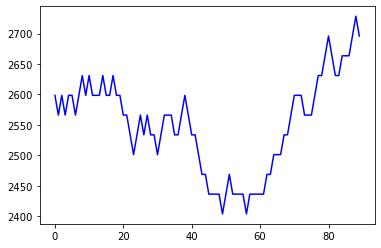

Episode:24 Score:-191 Angle:13.455179001263708


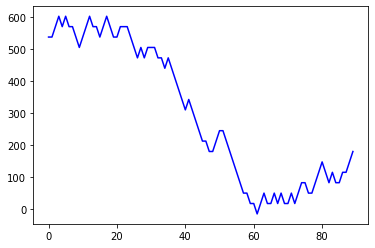

Episode:25 Score:-117 Angle:6.751012993536273


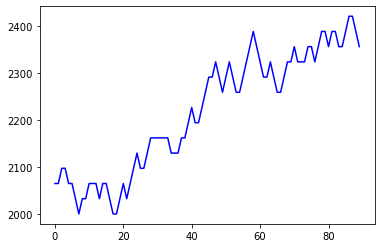

In [11]:
episodes = 25

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    powerArray = []
    anglesArray = []
    refPower = env.powerRef
    
    #powerArray.append(env.genPowerEuler)
    #anglesArray.append(env.angle)
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
        
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angle)
        
    print('Episode:{} Score:{} Angle:{}'.format(episode, score, n_state))
    
    #plt.title("Power"), plt.axhline(y=refPower, color='r', linestyle='-')
    plt.plot(powerArray, 'b')
    plt.show()
    
    #plt.title("Angle"), plt.plot(anglesArray)
    #plt.show()

# DQN Agent

In [88]:
states = env.observation_space.shape
actions = env.action_space.n

In [89]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape = states))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [90]:
model = build_model(states, actions)

In [91]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=BoltzmannQPolicy(), nb_actions=actions, nb_steps_warmup=1000)
    return dqn

# Traning

In [97]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=60000, visualize=False, verbose=1)

Training for 60000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: 0.9700
111 episodes - episode_reward: 86.667 [-437.000, 498.000] - loss: 39.109 - mae: 9.208 - mean_q: 13.770

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 68s 7ms/step - reward: 0.7438
111 episodes - episode_reward: 65.928 [-308.000, 590.000] - loss: 41.865 - mae: 10.196 - mean_q: 14.658

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 70s 7ms/step - reward: 0.5416
111 episodes - episode_reward: 53.036 [-519.000, 474.000] - loss: 42.984 - mae: 10.804 - mean_q: 15.153

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: 0.4421
111 episodes - episode_reward: 37.162 [-413.000, 583.000] - loss: 44.198 - mae: 11.323 - mean_q: 15.614

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: 0.9

# Testing

In [95]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 160.000, steps: 90
Episode 2: reward: 120.000, steps: 90
Episode 3: reward: -100.000, steps: 90
Episode 4: reward: 300.000, steps: 90
Episode 5: reward: 20.000, steps: 90
Episode 6: reward: 380.000, steps: 90
Episode 7: reward: 320.000, steps: 90
Episode 8: reward: 80.000, steps: 90
Episode 9: reward: -120.000, steps: 90
Episode 10: reward: -260.000, steps: 90
90.0


1393.379909084978
444.84184758165156
477.32277402711566
509.8037004725809
542.2846269180452
574.76555336351
607.2464798089748
639.7274062544395
672.2083326999043
639.727415147164
672.2083326999057
467.1981016801992
495.70168215224817
467.1980775179429
495.70168215224453
467.1980775179429
495.70168215224453
467.1980775179429
495.70168215224453
467.1980775179429
495.70168215224453
471.78008144217597
500.3893155126914
471.78008208387314
500.3893155126914
471.78008208387314
500.3893155126914
471.78008208387314
500.3893155126914
471.78008208387314
500.3893155126914
398.99331803225823
425.92459025072526
398.99330783867185
425.9245902507239
398.99330783867185
425.9245902507239
398.99330783867185
425.9245902507239
398.99330783867185
425.9245902507239
586.8902602025009
618.1531515508448
586.8902865169532
618.153151550848
586.8902865169532
618.153151550848
586.8902865169532
618.153151550848
586.8902865169532
618.153151550848
786.6393535074601
822.5070555688164
786.6393814817682
822.5070555688203

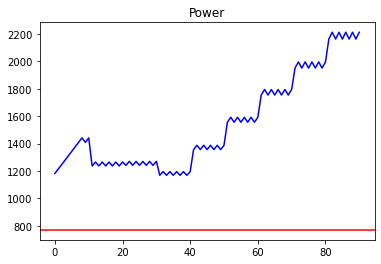

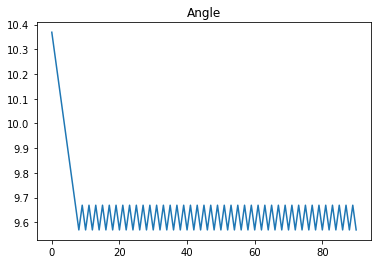

759.2210388647101
1964.3947596991277
1931.9138332536634
1899.4329068081986
1866.9519803627338
1834.4710539172688
1801.9901274718047
1769.50920102634
1737.028274580875
1704.5473481354102
1672.0664216899454
1642.3896079597446
1610.1566467224532
1577.9236851352475
1545.6907235480412
1513.457761960835
1481.2248003736286
1448.9918387864222
1416.7588771992157
1384.52591561201
1352.2929540248037
1400.757606664693
1372.3117634313735
1343.8659096696624
1315.4200559079502
1286.974202146238
1258.5283483845258
1230.0824946228133
1201.6366408611011
1173.190787099389
1144.7449333376765
1208.1633829044413
1182.6517057232109
1157.1400163682042
1131.6283270131958
1106.1166376581873
1080.6049483031788
1055.0932589481704
1029.5815695931622
1004.0698802381537
978.5581908831448
886.7017317557993
859.5839533695239
832.4661838454217
805.3484143213209
832.4661764210387
805.34841432132
832.4661764210387
805.34841432132
832.4661764210387
805.34841432132
673.1893272899877
642.3938170266911
673.1893049828923
642.

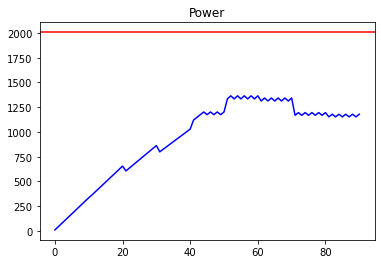

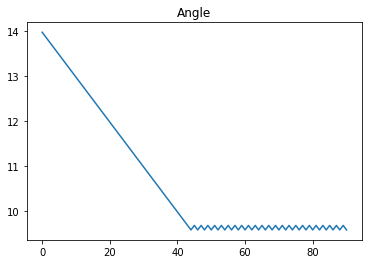

590.5735870203539
1274.1166608674312
1241.6357433146898
1274.1166608674318
1241.6357433146898
1274.1166608674318
1241.6357433146898
1274.1166608674318
1241.6357433146898
1274.1166608674318
1241.6357433146898
1261.6835801666039
1228.910837119737
1261.6835784246725
1228.9108371197365
1261.6835784246725
1228.9108371197365
1261.6835784246725
1228.9108371197365
1261.6835784246725
1228.9108371197365
1263.358524224731
1230.6250967389115
1263.3585244593983
1230.6250967389115
1263.3585244593983
1230.6250967389115
1263.3585244593983
1230.6250967389115
1263.3585244593983
1230.6250967389115
1418.9151503028943
1389.8329004596808
1418.9151720970858
1389.8329004596844
1418.9151720970858
1389.8329004596844
1418.9151720970858
1389.8329004596844
1418.9151720970858
1389.8329004596844
1405.3808013262478
1375.980855048673
1405.3807994300207
1375.980855048673
1405.3807994300207
1375.980855048673
1405.3807994300207
1375.980855048673
1405.3807994300207
1375.980855048673
1287.508210930079
1255.341596950864
128

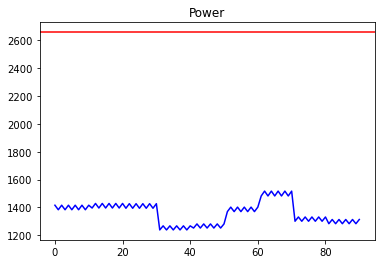

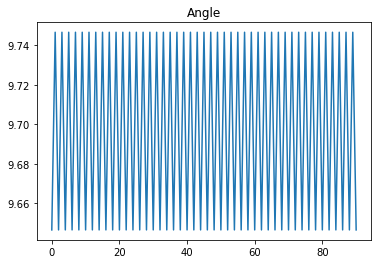

1223.4246420083173
467.65345617560183
435.1725386228602
467.6534561756023
435.1725386228602
467.6534561756023
435.1725386228602
467.6534561756023
435.1725386228602
467.6534561756023
435.1725386228602
453.895598715814
421.0959552589734
453.89559678884984
421.09595525897294
453.89559678884984
421.09595525897294
453.89559678884984
421.09595525897294
453.89559678884984
421.09595525897294
546.1590494838283
515.4968594038896
546.1590624065077
515.496859403891
546.1590624065077
515.496859403891
546.1590624065077
515.496859403891
546.1590624065077
515.496859403891
673.7201990788442
646.0131828654905
673.7202169454172
646.013182865493
673.7202169454172
646.013182865493
673.7202169454172
646.013182865493
673.7202169454172
646.013182865493
578.6200079646003
548.7098037925334
578.619994644597
548.7098037925318
578.619994644597
548.7098037925318
578.619994644597
548.7098037925318
578.619994644597
548.7098037925318
648.3449175816772
620.0500319590981
648.3449273475464
620.0500319590994
648.344927347

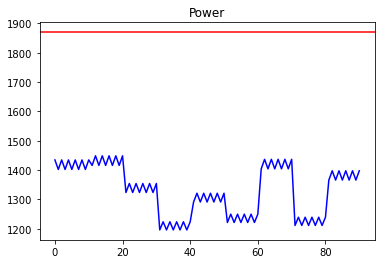

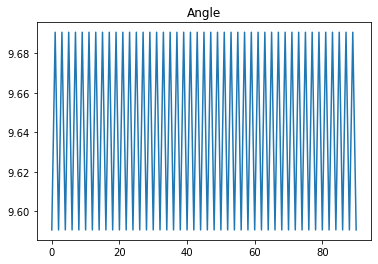

236.70492428425064
784.2385399752457
816.7194664207098
849.2003928661745
881.6813193116393
914.1622457571041
946.6431722025688
979.1240986480336
946.6431810952929
979.124098648035
946.6431810952929
939.0709202602729
905.6644622654462
939.0709146506354
905.6644622654458
939.0709146506354
905.6644622654458
939.0709146506354
905.6644622654458
939.0709146506354
905.6644622654458
1091.5116322504618
1061.6277479819173
1091.5116536005066
1061.62774798192
1091.5116536005066
1061.62774798192
1091.5116536005066
1061.62774798192
1091.5116536005066
1061.62774798192
1117.1502905382192
1087.8588371624
1117.1502941290319
1087.8588371624003
1117.1502941290319
1087.8588371624003
1117.1502941290319
1087.8588371624003
1117.1502941290319
1087.8588371624003
1129.025700136222
1100.0086575598643
1129.0257017994288
1100.0086575598646
1129.0257017994288
1100.0086575598646
1129.0257017994288
1100.0086575598646
1129.0257017994288
1100.0086575598646
1245.198911331088
1218.866373241507
1245.1989276016968
1218.8663

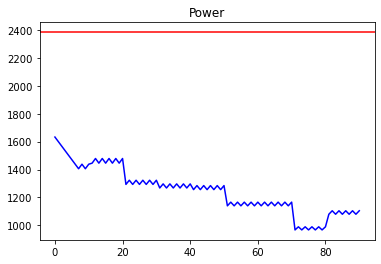

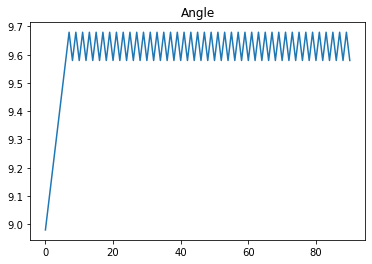

594.9977522181237
1076.7965684505095
1109.2774948959739
1141.7584213414386
1174.2393477869034
1206.7202742323682
1239.201200677833
1271.6821271232973
1304.1630535687625
1336.6439800142273
1369.124906459692
1466.4344115840852
1497.4453750536652
1466.434429150064
1497.4453750536677
1466.434429150064
1497.4453750536677
1466.434429150064
1497.4453750536677
1466.434429150064
1497.4453750536677
1510.4770376109932
1540.489334383022
1510.4770435033442
1540.4893343830227
1510.4770435033442
1540.4893343830227
1510.4770435033442
1540.4893343830227
1510.4770435033442
1540.4893343830227
1613.7796582874694
1641.44960228651
1613.7796721080695
1641.4496022865123
1613.7796721080695
1641.4496022865123
1613.7796721080695
1641.4496022865123
1613.7796721080695
1641.4496022865123
1508.6383866836115
1538.6923548891154
1508.6383726170202
1538.6923548891132
1508.6383726170202
1538.6923548891132
1508.6383726170202
1538.6923548891132
1508.6383726170202
1538.6923548891132
1381.0661102772497
1414.0127443120487
138

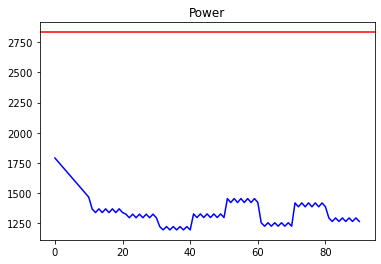

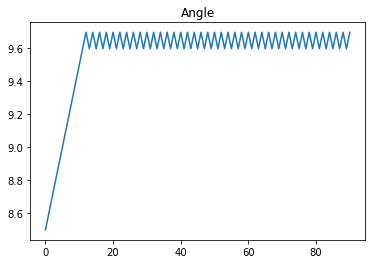

186.31312700351873
1320.641821278366
1288.1608948329022
1255.6799683874378
1223.199041941973
1190.7181154965078
1158.237189051043
1125.7562626055787
1093.2753361601135
1060.7944097146487
1028.3134832691844
1124.8030126369208
1090.493189631372
1056.1833487205063
1021.8735078096379
987.5636668987695
953.2538259879007
918.9439850770327
884.6341441661643
850.3243032552955
816.0144623444276
614.7171040057046
583.1665663969802
551.6160520251501
520.0655376533223
488.5150232814949
456.9645089096671
425.4139945378397
393.86348016601187
362.31296579418404
330.7624514223571
197.76268495797126
168.22035691968722
138.6780430438439
109.13572916800331
79.59341529216226
50.05110141632122
Episode:7 Score:330 Steps:37 Power:1315.1499241180313


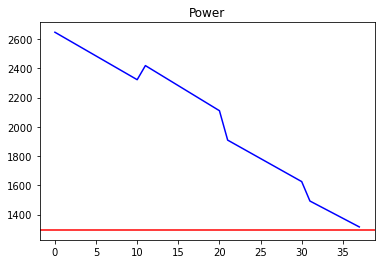

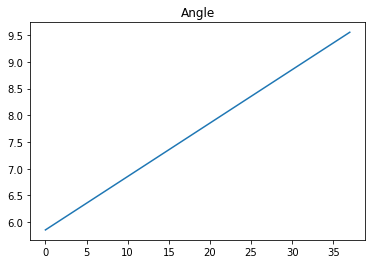

928.8748050108168
2464.5055347337543
2432.024608288291
2399.543681842826
2367.062755397361
2334.581828951896
2302.1009025064313
2269.619976060966
2237.1390496155013
2204.6581231700375
2172.1771967245727
2224.126418244482
2195.4382489314835
2166.750068579913
2138.0618882283416
2109.3737078767704
2080.6855275251983
2051.9973471736266
2023.3091668220554
1994.6209864704836
1965.9328061189117
1969.3004169099468
1941.605881360464
1913.9113415588388
1886.216801757213
1858.522261955587
1830.8277221539608
1803.1331823523349
1775.438642550709
1747.744102749083
1720.049562947457
1814.9401333391395
1790.1462807600064
1765.352411797096
1790.14627397187
1765.3524117970946
1790.14627397187
1765.3524117970946
1790.14627397187
1765.3524117970946
1790.14627397187
1655.4029333206456
1682.6808992871545
1655.4029186095515
1682.6808992871527
1655.4029186095515
1682.6808992871527
1655.4029186095515
1682.6808992871527
1655.4029186095515
1682.6808992871527
1473.4337913324703
1504.8230256995957
1473.43376698524

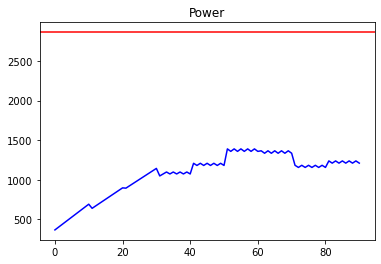

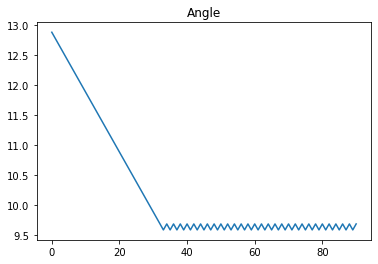

675.0160706502088
1138.4167694926941
1105.9358430472303
1073.4549166017655
1040.9739901563007
1008.4930637108362
976.0121372653714
943.5312108199066
911.0502843744414
878.5693579289766
846.0884314835123
897.105535712386
863.1429639794308
829.1803806134824
795.217797247532
761.2552138815813
727.2926305156313
693.3300471496809
659.3674637837303
625.4048804177796
591.4422970518299
745.3197642040593
707.3049563736408
669.2901222748055
631.2752881759659
669.2901118669915
631.2752881759645
669.2901118669915
631.2752881759645
669.2901118669915
631.2752881759645
780.1153700455109
739.6019368973045
780.1153848745062
739.6019368973066
780.1153848745062
739.6019368973066
780.1153848745062
739.6019368973066
780.1153848745062
739.6019368973066
661.2497008488087
623.4161376480768
661.2496849439628
623.4161376480745
661.2496849439628
623.4161376480745
661.2496849439628
623.4161376480745
661.2496849439628
623.4161376480745
556.0852115683338
520.6226485774164
556.0851974967813
520.6226485774141
556.085

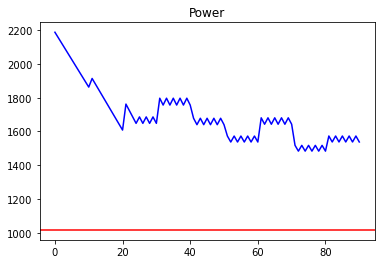

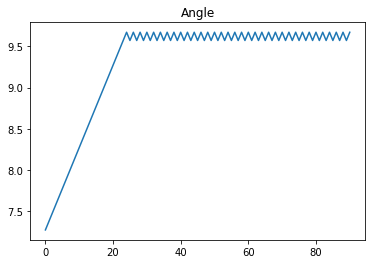

1769.9284624399193
609.635963526322
577.1550370808577
544.6741106353934
512.1931841899286
479.7122577444634
447.23133129899907
414.7504048535343
382.2694784080695
349.78855196260474
317.30762551713997
91.18684030617487
61.29475781315614
Episode:10 Score:130 Steps:13 Power:2176.0533052542532


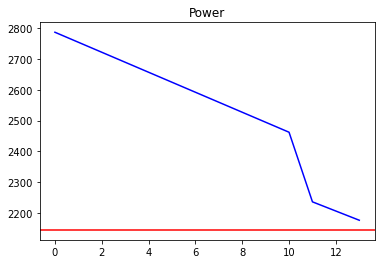

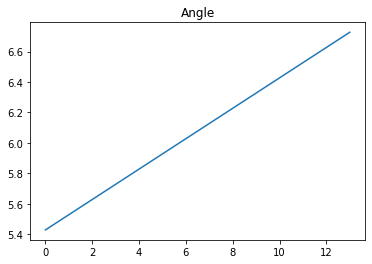

776.178924358722
59.893921746727074
Episode:11 Score:20 Steps:2 Power:1433.4335271579237


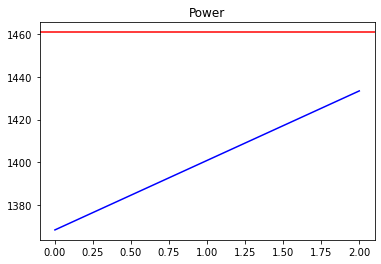

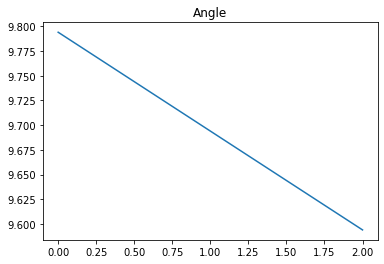

530.1355591594015
400.9728530971522
368.49192665168744
336.0110002062231
303.5300737607579
271.04914731529357
238.5682208698288
206.08729442436402
173.6063679788988
141.12544153343447
108.6445150879697
53.75829384869735
83.65614200547566
113.55397202345375
143.45180204142935
173.34963205940494
203.2474620773803
233.14529209535613
263.04312211333195
233.14530028087256
263.04312211333263
387.51860559054353
413.9314847605949
387.51862624587466
413.93148476059787
387.51862624587466
413.93148476059787
387.51862624587466
413.93148476059787
387.51862624587466
413.93148476059787
363.37474988608164
390.3326509817964
363.3747466556024
390.3326509817962
363.3747466556024
390.3326509817962
363.3747466556024
390.3326509817962
363.3747466556024
390.3326509817962
246.35500693996119
275.9546055828048
246.3549912825813
275.9546055828025
246.3549912825813
275.9546055828025
246.3549912825813
275.9546055828025
246.3549912825813
275.9546055828025
224.12212591104458
254.2236421488151
224.12212293626067
254.

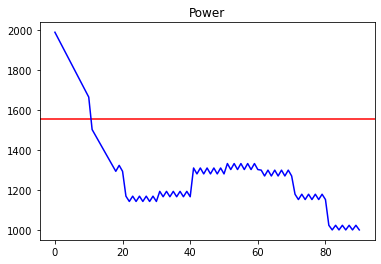

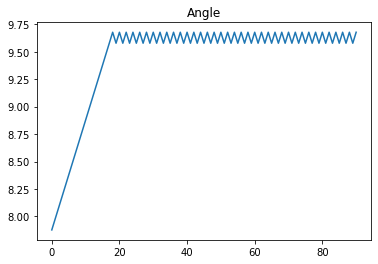

1325.3064573014792
1833.2180725519916
1800.7371461065272
1768.2562196610625
1735.7752932155977
1703.2943667701336
1670.8134403246686
1638.3325138792038
1605.851587433739
1573.3706609882738
1540.889734542809
1474.3061865046743
1439.9462696057237
1405.5863571179134
1371.2264446301033
1336.8665321422934
1302.5066196544835
1268.146707166674
1233.7867946788642
1199.4268821910541
1165.0669697032445
1258.8569452466666
1229.0495277143002
1199.242093262504
1169.434658810706
1139.6272243589078
1109.8197899071092
1080.012355455311
1050.2049210035127
1020.3974865517143
990.590052099916
1027.7089638686346
999.6558571169669
971.6027414438051
943.5496257706429
915.4965100974798
887.4433944243171
859.3902787511545
887.4433867438524
859.3902787511536
887.4433867438524
926.7964269155507
953.3227732030862
926.7964359338773
953.3227732030875
926.7964359338773
953.3227732030875
926.7964359338773
953.3227732030875
926.7964359338773
953.3227732030875
747.1793455640718
777.7740431036339
747.1793215329467
777.

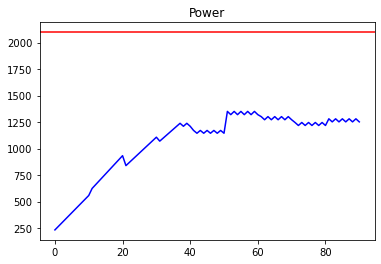

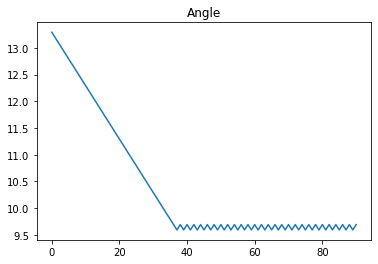

128.15437247020418
1049.661620629319
1017.1806941838552
984.6997677383904
952.2188412929256
919.7379148474613
887.2569884019963
854.7760619565311
822.2951355110667
789.8142090656015
757.3332826201367
564.9739330499237
535.2717951387706
505.56967949400405
475.8675638492409
446.16544820447734
416.46333255971376
386.7612169149502
357.05910127018706
327.3569856254235
297.6548699806599
455.6991719973453
422.0474231683063
388.3956480977115
354.7438730271133
321.09209795651464
287.440322885916
321.0920887432319
287.4403228859144
321.0920887432319
287.4403228859144
409.3437535306723
373.6648496063517
409.34376533407476
373.6648496063531
409.34376533407476
373.6648496063531
409.34376533407476
373.6648496063531
409.34376533407476
373.6648496063531
304.0184275685683
270.75883165898995
304.0184134816111
270.7588316589879
304.0184134816111
270.7588316589879
304.0184134816111
270.7588316589879
304.0184134816111
270.7588316589879
202.83547000732437
171.90005733144903
202.83545647440064
171.9000573314

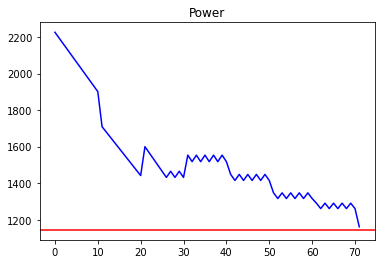

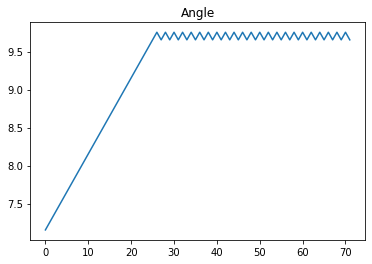

589.0998252611193
1091.7761193390656
1059.2951928936016
1026.8142664481375
994.3333400026727
961.8524135572078
929.3714871117429
896.890560666278
864.4096342208136
831.9287077753487
799.4477813298838
853.5884448286968
824.1921464281597
794.7958365921236
765.3995267560861
736.0032169200488
706.6069070840115
677.210597247974
647.8142874119362
618.4179775758992
589.0216677398616
645.6943108636544
618.5581197872411
591.4219172381127
564.2857146889826
537.1495121398527
510.01330959072266
482.8771070415926
510.01330216129304
482.87710704159144
510.01330216129304
381.7305149344654
411.16121641538575
381.73050140245755
411.1612164153837
381.73050140245755
411.1612164153837
381.73050140245755
411.1612164153837
381.73050140245755
411.1612164153837
399.3022146631697
428.3343160697027
399.3022170140207
428.33431606970316
399.3022170140207
428.33431606970316
399.3022170140207
428.33431606970316
399.3022170140207
428.33431606970316
581.325459024818
606.2283681791628
581.3254833769979
606.22836817916

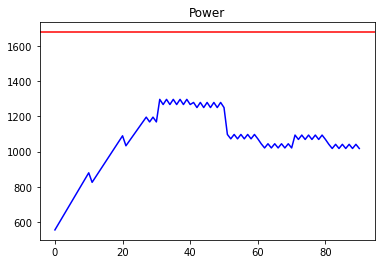

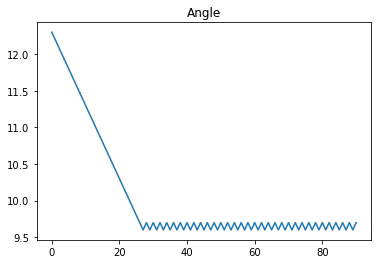

212.83192384690938
1274.7811627926164
1242.300236347153
1274.7811538998928
1242.3002363471517
1274.7811538998928
1242.3002363471517
1274.7811538998928
1242.3002363471517
1274.7811538998928
1242.3002363471517
1368.412457891799
1333.8104203621049
1368.4124704187632
1333.8104203621065
1368.4124704187632
1333.8104203621065
1368.4124704187632
1333.8104203621065
1368.4124704187632
1333.8104203621065
1467.337303478435
1430.4942140399312
1467.3373167136226
1430.4942140399328
1467.3373167136226
1430.4942140399328
1467.3373167136226
1430.4942140399328
1467.3373167136226
1430.4942140399328
1623.8419789383333
1583.4534256367242
1623.841999877146
1583.453425636727
1623.841999877146
1583.453425636727
1623.841999877146
1583.453425636727
1623.841999877146
1583.453425636727
1760.4217628769686
1716.9391159130569
1760.4217811500223
1716.9391159130594
1760.4217811500223
1716.9391159130594
1760.4217811500223
1716.9391159130594
1760.4217811500223
1716.9391159130594
1634.2949856302173
1593.669591991536
1634.

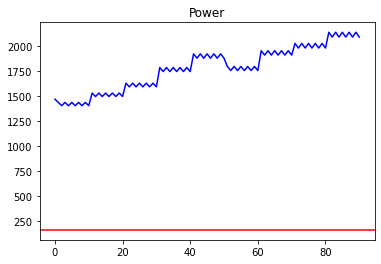

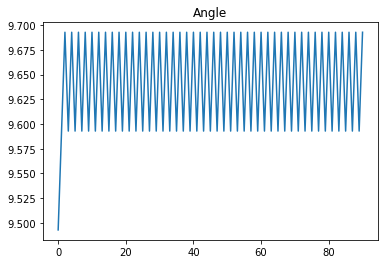

2349.6980591950887
155.26334111956157
187.74426756502498
220.22519401048976
252.706120455955
285.18704690141976
317.6679733468841
350.14889979234886
382.6298262378141
415.1107526832784
447.5916791287432
772.7768957331839
800.8387444867881
828.9005525667358
856.9623606466776
885.0241687266191
913.0859768065607
941.1477848865024
969.2095929664442
997.2714010463858
1025.3332091263273
1173.8281994937042
1199.7484533019767
1225.6686903308114
1251.5889273596442
1277.5091643884768
1303.4294014173097
1329.3496384461425
1355.2698754749752
1381.1901125038078
1407.1103495326404
1450.4665478531474
1476.0096786326967
1501.5528069737893
1527.0959353148814
1501.5528139670623
1527.0959353148828
1501.5528139670623
1527.0959353148828
1501.5528139670623
1527.0959353148828
1390.055018335191
1418.1186511461271
1390.05500341713
1418.1186511461249
1390.05500341713
1418.1186511461249
1390.05500341713
1418.1186511461249
1390.05500341713
1418.1186511461249
1270.1392891602748
1300.9137432391103
1270.139273115921

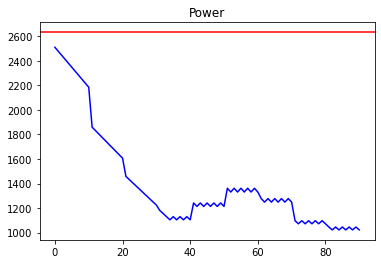

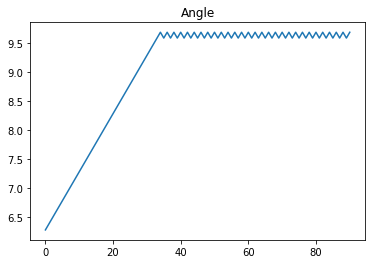

140.29241008674808
68.91093785950034
36.430011414036926
Episode:18 Score:30 Steps:3 Power:2393.7411743909192


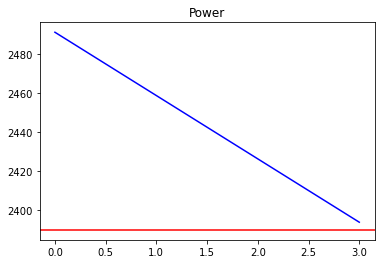

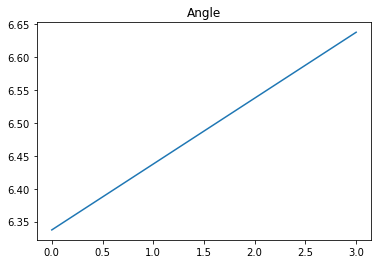

2166.3237858938896
2037.2946686208936
2004.8137421754293
1972.3328157299652
1939.8518892845004
1907.3709628390357
1874.8900363935707
1842.4091099481057
1809.9281835026409
1777.4472570571768
1744.9663306117118
1734.7389819867976
1703.5026668564515
1672.2663488501564
1641.0300308438611
1609.7937128375663
1578.557394831271
1547.3210768249755
1516.0847588186807
1484.8484408123854
1453.6121228060902
1328.352117880816
1293.7433431095922
1259.134580747749
1224.5258183859075
1189.9170560240666
1155.3082936622252
1120.6995313003838
1086.0907689385433
1051.482006576702
1016.8732442148605
1058.4662685679807
1025.8691802027101
993.2720816814444
960.6749831601774
928.0778846389112
895.4807861176441
862.8836875963775
895.4807771931144
862.8836875963764
895.4807771931144
646.3663579005174
683.8977250857424
646.3663289366004
683.8977250857383
646.3663289366004
683.8977250857383
646.3663289366004
683.8977250857383
646.3663289366004
683.8977250857383
452.8723979624581
494.81338464393366
452.872372078422

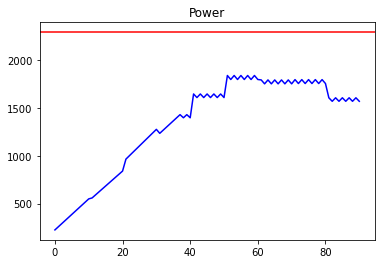

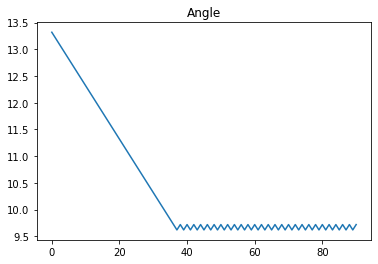

466.083223457395
1292.6127186873841
1260.1317922419203
1227.6508657964555
1195.1699393509903
1162.689012905526
1130.2080864600612
1097.727160014596
1065.2462335691312
1032.7653071236668
1000.2843806782016
693.6774779073826
664.9033119355654
636.1291839966816
607.3550560578028
578.5809281189249
549.8068001800466
521.0326722411683
492.2585443022899
463.48441636341204
434.7102884245337
664.7430405671626
631.922069908393
599.1010632671891
566.2800566259798
533.4590499847704
500.63804334356087
467.8170367023515
434.9960300611426
402.17502341993304
369.3540167787237
551.1924755071377
514.3928032576719
477.5931010785091
440.79339889934204
403.99369672017565
367.1939945410088
330.39429236184196
293.59459018267535
256.7948880035083
219.99518582434143
322.1327129887709
282.17193354462233
322.13272150023795
282.1719335446237
322.13272150023795
282.1719335446237
322.13272150023795
282.1719335446237
322.13272150023795
282.1719335446237
454.0430689918994
411.0810782453432
454.04308663846314
411.0810

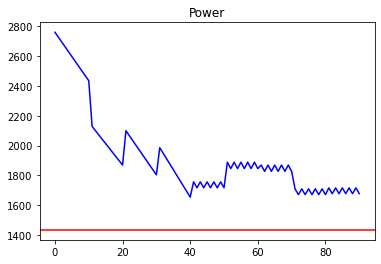

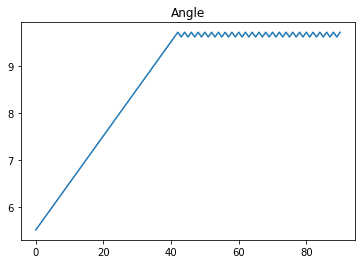

103.25223681405396
926.1883052767769
958.6692317222412
991.150158167706
1023.6310846131712
991.15016706043
1023.6310846131721
991.15016706043
1023.6310846131721
991.15016706043
1023.6310846131721
968.0170418269249
1001.0197360302041
968.0170387316241
1001.0197360302036
968.0170387316241
1001.0197360302036
968.0170387316241
1001.0197360302036
968.0170387316241
1001.0197360302036
952.4755197799414
985.8287620922627
952.4755177004267
985.8287620922622
952.4755177004267
985.8287620922622
952.4755177004267
985.8287620922622
952.4755177004267
985.8287620922622
918.1983262863976
952.3247060823476
918.1983216999774
952.3247060823473
918.1983216999774
952.3247060823473
918.1983216999774
952.3247060823473
918.1983216999774
952.3247060823473
995.999931248627
1028.3714700220726
995.9999416587812
1028.3714700220744
995.9999416587812
1028.3714700220744
995.9999416587812
1028.3714700220744
995.9999416587812
1028.3714700220744
813.7141255403237
850.1971814907743
813.7141011497818
850.1971814907711
813

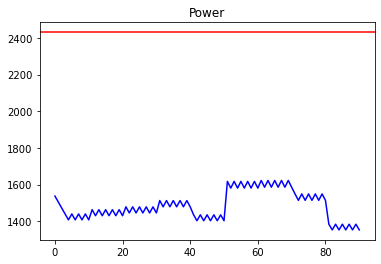

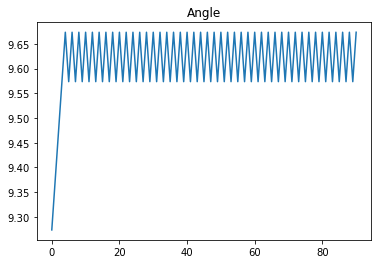

472.64785044490736
208.9763869145354
176.495460469072
144.01453402360767
111.53360757814244
79.05268113267766
46.57175468721289
Episode:22 Score:70 Steps:7 Power:2676.4744667841082


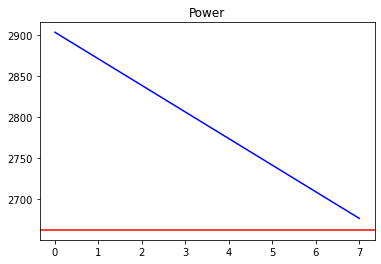

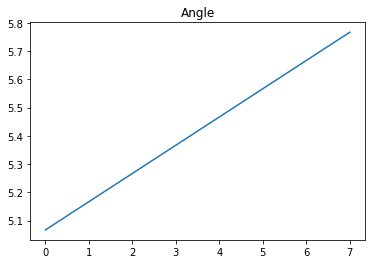

73.85764523884018
1371.2020151050335
1338.7210886595697
1306.2401622141053
1273.7592357686406
1241.2783093231753
1208.797382877711
1176.3164564322462
1143.835529986781
1111.3546035413167
1078.873677095852
1025.9532369804153
993.7513779297312
961.549521715245
929.3476655007587
897.145809286272
864.9439530717862
832.7420968572999
800.5402406428136
768.3383844283273
736.1365282138411
590.8829544201521
560.4687024902803
530.0544662809332
499.6402300715881
469.22599386224306
438.8117576528982
408.39752144355316
377.98328523420787
347.5690490248628
317.15481281551797
276.2876273362672
246.0697206293621
215.85181538025313
185.6339101311437
155.41600488203426
125.1980996329255
94.98019438381607
64.76228913470663
34.544383885597426
Episode:23 Score:380 Steps:40 Power:1336.8848253135511


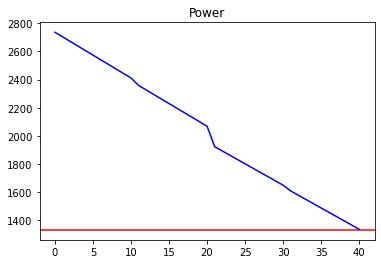

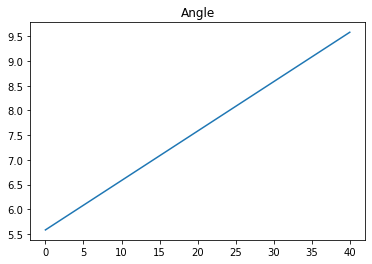

1004.6408454500495
859.1121755044965
826.6312490590323
794.1503226135674
761.6693961681033
729.1884697226384
696.7075432771735
664.2266168317086
631.7456903862437
599.2647639407788
566.783837495314
546.9981066513874
515.1189727865949
483.2398372663198
451.3607017460438
419.4815662257679
387.60243070549245
355.72329518521644
323.84415966494055
291.96502414466465
260.0858886243892
142.73552619166117
108.1077274594063
73.4799400511663
38.85215264292742
Episode:24 Score:250 Steps:25 Power:1215.286233495924


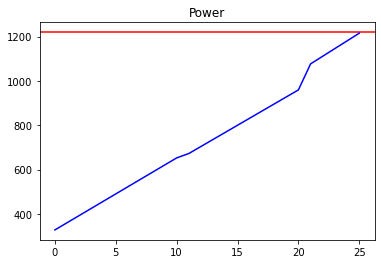

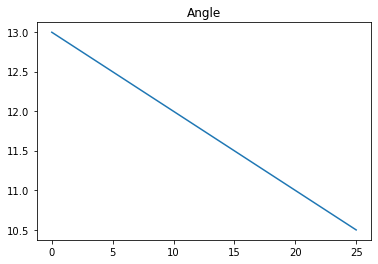

890.6991721974084
1344.5862141209357
1312.1052876754716
1279.6243612300068
1247.143434784542
1214.6625083390772
1182.1815818936125
1149.7006554481477
1117.219729002683
1084.7388025572182
1052.2578761117538
778.7799194283757
750.764542385366
722.7491989440916
694.7338555028218
666.718512061552
638.703168620282
610.6878251790126
582.6724817377428
554.6571382964728
526.6417948552034
616.606755773975
585.9080856446678
616.606763887025
585.908085644669
616.606763887025
585.908085644669
616.606763887025
585.908085644669
616.606763887025
585.908085644669
784.4359179098526
749.9201580752517
784.4359403617079
749.9201580752544
784.4359403617079
749.9201580752544
784.4359403617079
749.9201580752544
784.4359403617079
749.9201580752544
856.6928347813353
820.5336523168394
856.6928444477207
820.5336523168407
856.6928444477207
820.5336523168407
856.6928444477207
820.5336523168407
856.6928444477207
820.5336523168407
868.5554400875249
832.126446826343
868.5554416744794
832.1264468263432
868.55544167447

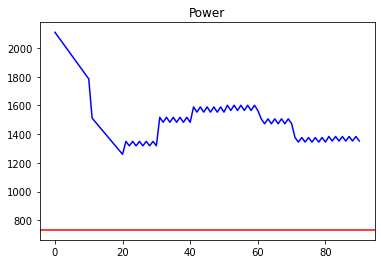

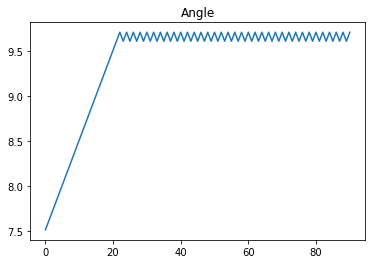

In [96]:
episodes = 25

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    powerArray = []
    anglesArray = []
    refPower = env.powerRef
    initTrainingLenght = env.training_length
    
    powerArray.append(env.genPowerEuler)
    anglesArray.append(env.angle)
    
    while not done:
        print(env.error)
        action = dqn.forward(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        
        if env.training_length % 10 == 0:
            env.wind += random.uniform(-0.5,0.5)
        
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angle)
        
        if env.error <= 33.0:
            break
        
    print('Episode:{} Score:{} Steps:{} Power:{}'.format(episode, score, initTrainingLenght - env.training_length, env.genPowerEuler))
    
    plt.title("Power"), plt.axhline(y=refPower, color='r', linestyle='-')
    plt.plot(powerArray, 'b')
    plt.show()
    
    plt.title("Angle"), plt.plot(anglesArray)
    plt.show()